In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

import warnings
warnings.filterwarnings("ignore")

#My imports
import wrangle as w
import env
import model as m

In [2]:
df = w.get_zillow_data()

In [3]:
df.head(2)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,transactiondate,parcelid
0,4.0,3.5,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,1023282.0,2017-01-01,14297519
1,2.0,1.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,464000.0,2017-01-01,17052889


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52442 non-null  float64
 1   bathroomcnt                   52442 non-null  float64
 2   calculatedfinishedsquarefeet  52360 non-null  float64
 3   fips                          52442 non-null  float64
 4   latitude                      52442 non-null  float64
 5   longitude                     52442 non-null  float64
 6   lotsizesquarefeet             52073 non-null  float64
 7   yearbuilt                     52326 non-null  float64
 8   taxvaluedollarcnt             52441 non-null  float64
 9   transactiondate               52442 non-null  object 
 10  parcelid                      52442 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 4.4+ MB


In [5]:
#Clean the data
df = w.clean_zillow(df)

In [6]:
df.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
0,4,3.5,3100,6059,33634931.0,-117869207.0,4506.0,1998,1023282,2017-01-01,14297519,Orange,19
1,2,1.0,1465,6111,34449266.0,-119281531.0,12647.0,1967,464000,2017-01-01,17052889,Ventura,50


In [ ]:
df.info()

In [ ]:
## Need to find a place to create dummies
#Make dummy variables from county
## df = pd.get_dummies(df, columns=['county'], drop_first=False)

In [ ]:
df.info()

In [ ]:
#Checking to make sure we have no null values
df.isnull().sum()

In [8]:
#Splitting our data
train, validate, test = w.train_validate_test_split(df)

In [9]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922,6111,34291222.0,-119214999.0,7884.0,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660,6037,34113036.0,-117867106.0,7656.0,1962,512588,2017-01-09,13036208,Los Angeles,55


In [10]:
print(f' Train length is {len(train)} rows')
print(f' Validate length is {len(validate)} rows')
print(f' Test length is {len(test)} rows')

 Train length is 34937 rows
 Validate length is 7489 rows
 Test length is 7488 rows


In [ ]:
train.head(2)

In [11]:
#Breaking down continuous vs categorical variables
cat_vars = ['bedrooms', 'county']
cont_vars = ['bathrooms', 'square_feet', 'lot_size', 'tax_value', 'home_age']

In [12]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            plt.show()

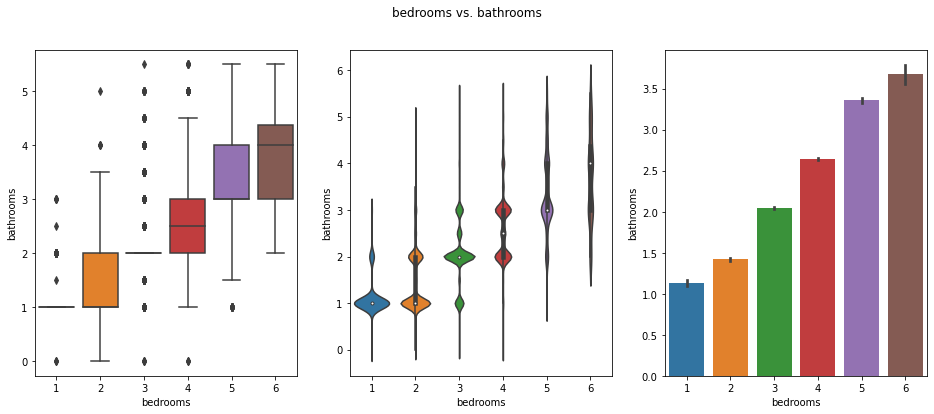

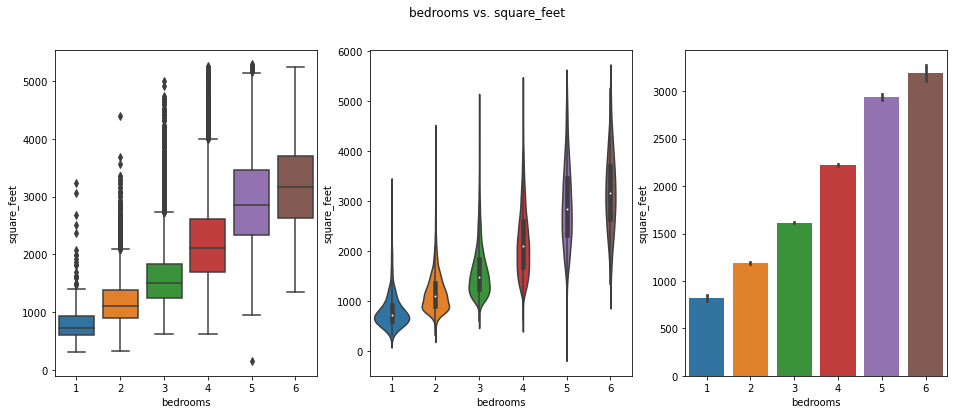

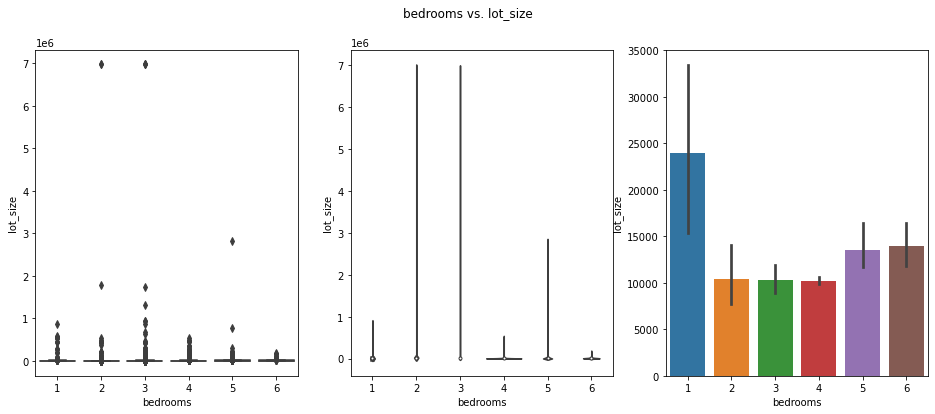

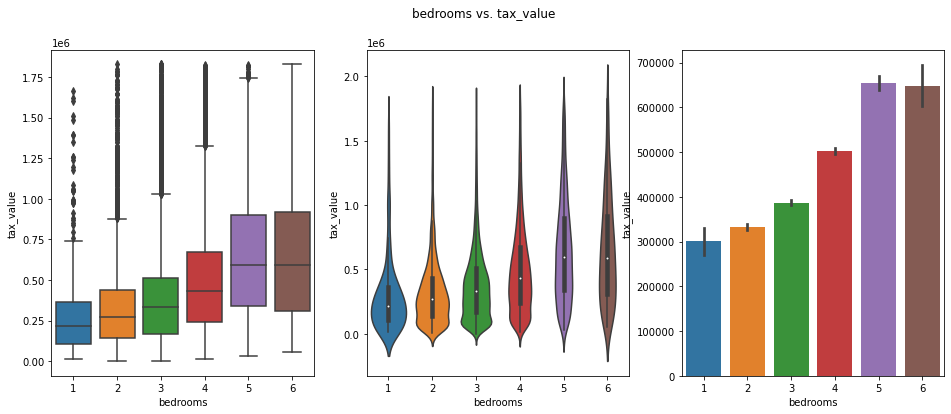

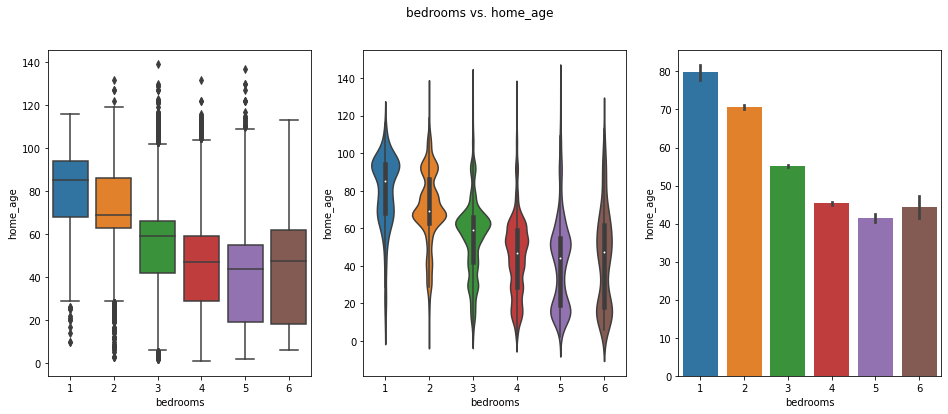

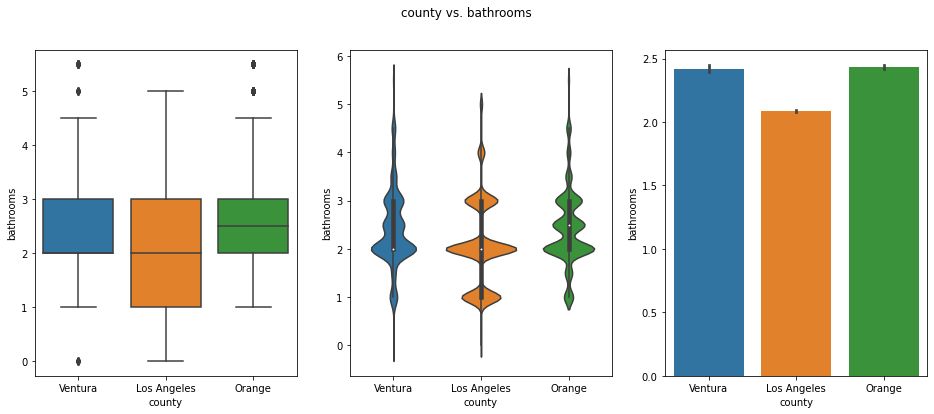

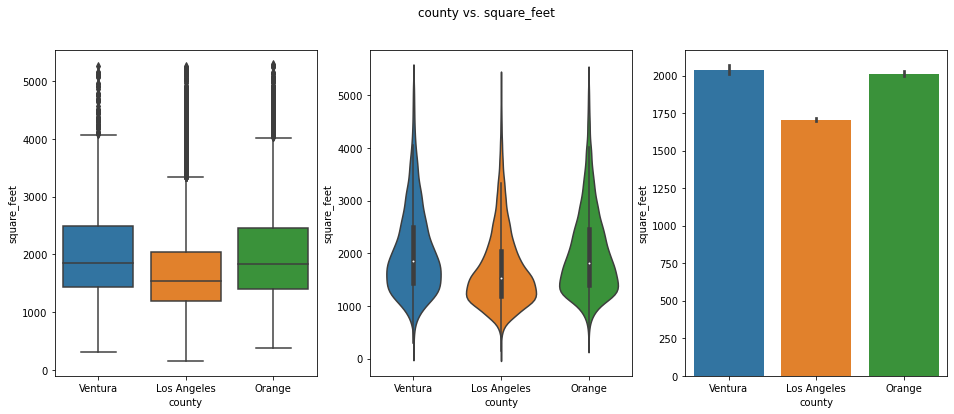

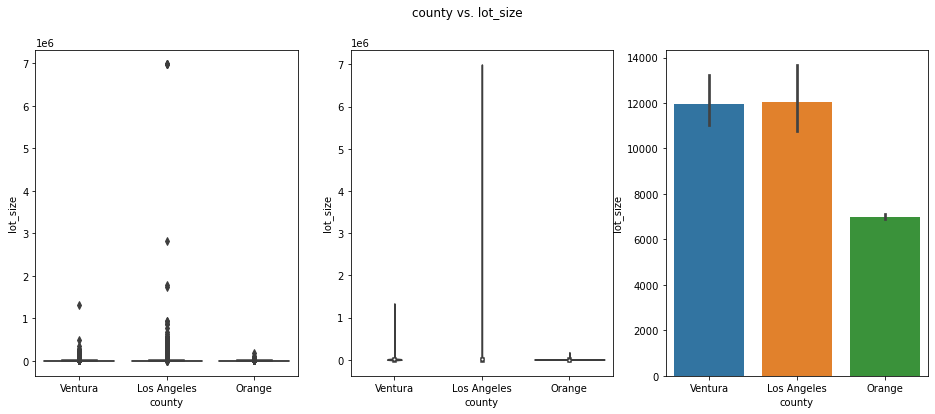

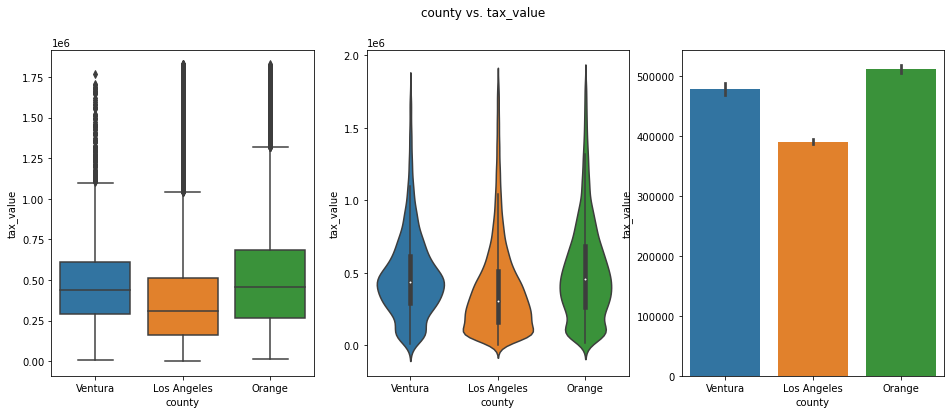

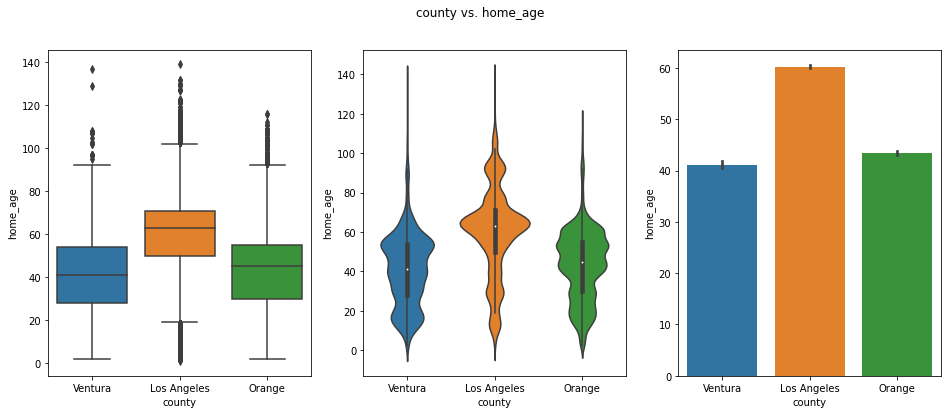

In [13]:
plot_categorical_and_continuous_vars(train, cat_vars, cont_vars)

## Categorical Variable Exploration

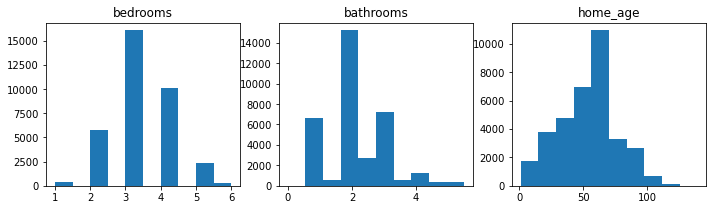

In [19]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms', 'home_age']
for i, col in enumerate(cols):
    # i starts at 0, but plot nos should start at 1
    subplot_num = i+1
    # Create subplot.
    plt.subplot(1,4,subplot_num)
    # Title with column name.
    plt.title(col)
    # Display histogram for column.
    train[col].hist(bins=10)
    # Hide gridlines.
    plt.grid(False)

bedrooms
3    16053
4    10102
2     5719
5     2371
1      394
6      298
Name: bedrooms, dtype: int64
3    45.948421
4    28.914904
2    16.369465
5     6.786501
1     1.127744
6     0.852964
Name: bedrooms, dtype: float64


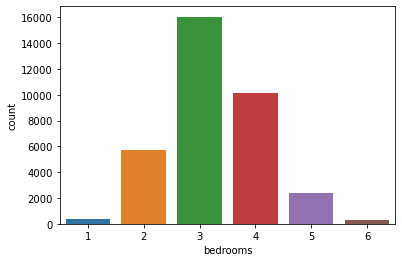

county
Los Angeles    22630
Orange          9365
Ventura         2942
Name: county, dtype: int64
Los Angeles    64.773736
Orange         26.805393
Ventura         8.420872
Name: county, dtype: float64


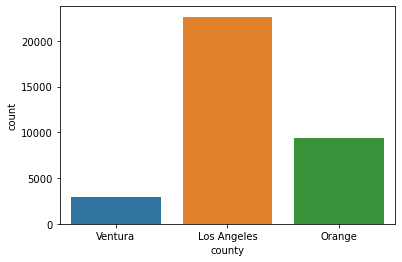

In [14]:
for col in cat_vars:
    print(col)
    print(train[col].value_counts())
    print(train[col].value_counts(normalize=True)*100)
    sns.countplot(x=col, data=train)
    plt.show()

### Bedrooms

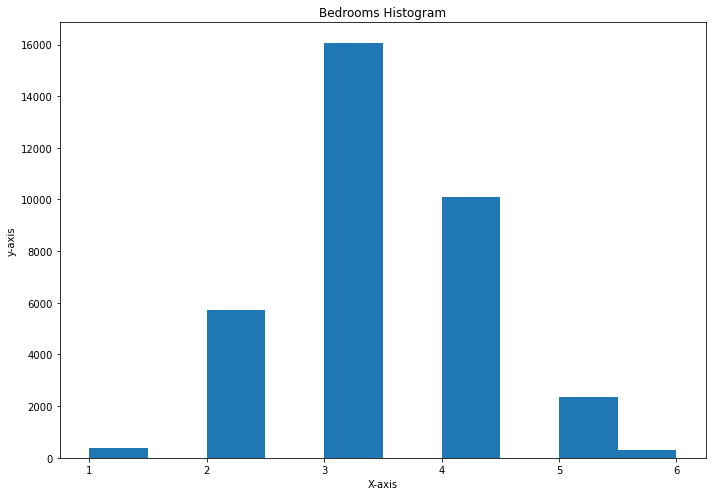

In [15]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7), tight_layout = True)
ax.hist(train.bedrooms)
plt.xlabel("X-axis")
plt.ylabel("y-axis")
plt.title('Bedrooms Histogram')
 
# Show plot
plt.show()

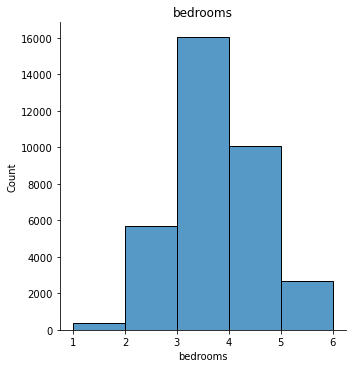

In [16]:
#Displot
sns.displot(x='bedrooms', data=train, bins=5)
plt.title('bedrooms')
plt.show()

### Continuous Variable Exploration

Mean bathrooms is: 2.206528894867905


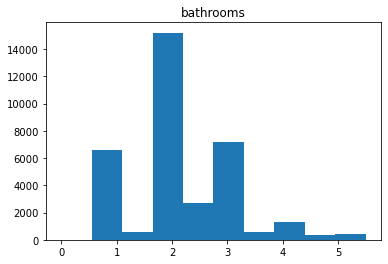

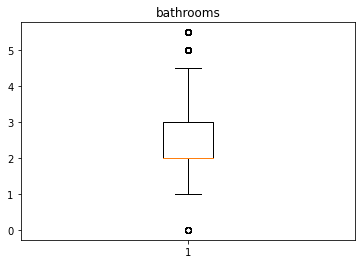

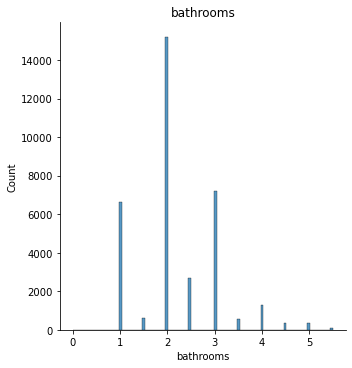

Mean square_feet is: 1815.3709248075106


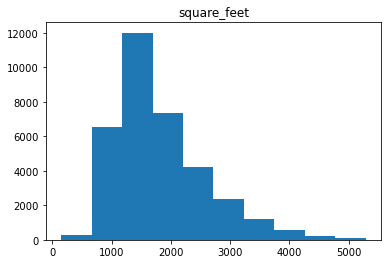

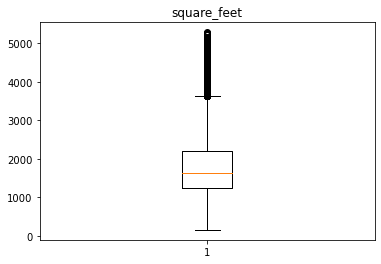

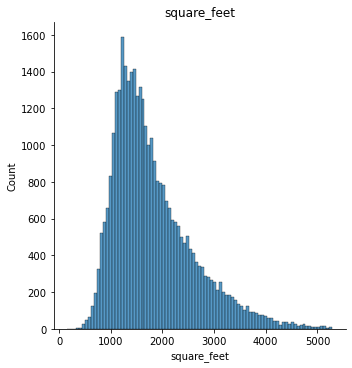

Mean lot_size is: 10686.156166814551


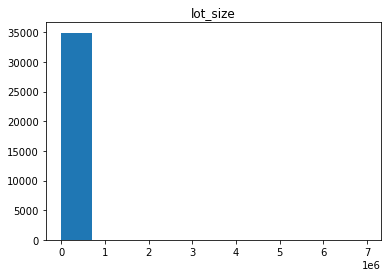

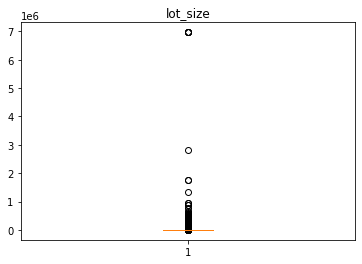

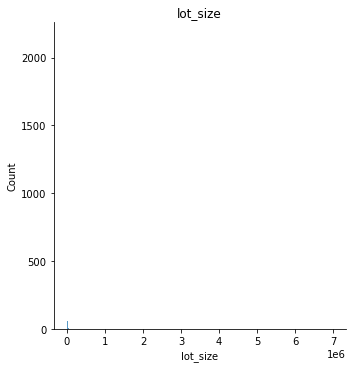

Mean tax_value is: 430893.2876034004


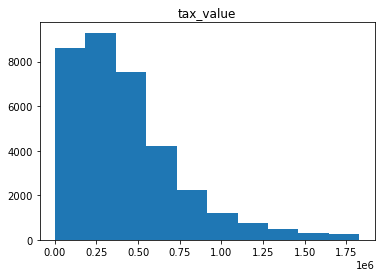

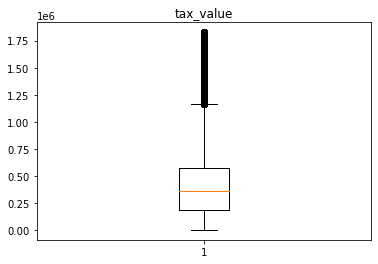

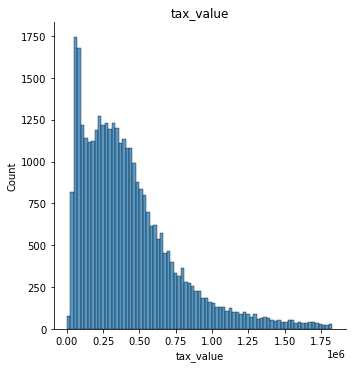

Mean home_age is: 54.1040730457681


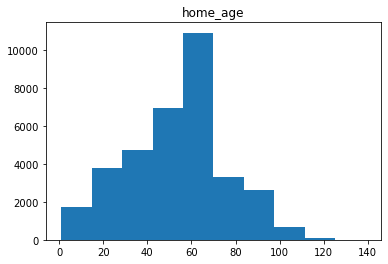

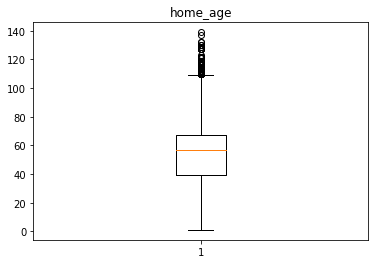

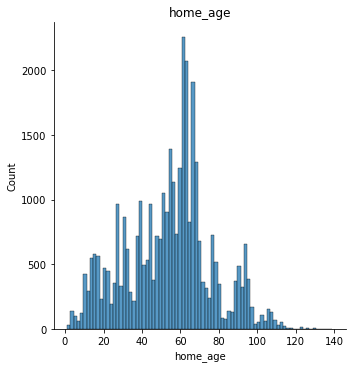

In [25]:
#Visualize other numeric data
# Plot numeric columns
for col in cont_vars:
    print(f'Mean {col} is: {train[col].mean()}')
    plt.hist(train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(train[col])
    plt.title(col)
    plt.show()
    sns.displot(train[col])
    plt.title(col)
    plt.show()

In [20]:
#Descriptive statistics
print(f'Mean bedrooms = {train.bedrooms.mean()}')
print(f'Median Bedrooms = {train.bedrooms.median()}')
print(f'Mode Bedrooms = {train.bedrooms.mode()}')
print(f'Max Bedrooms = {train.bedrooms.max()}')
print(f'Min Bedrooms = {train.bedrooms.min()}')

Mean bedrooms = 3.2642184503534932
Median Bedrooms = 3.0
Mode Bedrooms = 0    3
Name: bedrooms, dtype: int64
Max Bedrooms = 6
Min Bedrooms = 1


In [21]:
#Bathrooms in train data set
train.bathrooms.value_counts()

2.0    15197
3.0     7202
1.0     6622
2.5     2689
4.0     1298
1.5      589
3.5      551
4.5      369
5.0      338
5.5       71
0.0       11
Name: bathrooms, dtype: int64

In [22]:
#Descriptive statistics of bathrooms
print(f'Mean Bathrooms = {train.bathrooms.mean()}')
print(f'Median Bathrooms = {train.bathrooms.median()}')
print(f'Mode Bathrooms = {train.bathrooms.mode()}')
print(f'Max Bathrooms = {train.bathrooms.max()}')
print(f'Min Bathrooms = {train.bathrooms.min()}')

Mean Bathrooms = 2.206528894867905
Median Bathrooms = 2.0
Mode Bathrooms = 0    2.0
Name: bathrooms, dtype: float64
Max Bathrooms = 5.5
Min Bathrooms = 0.0


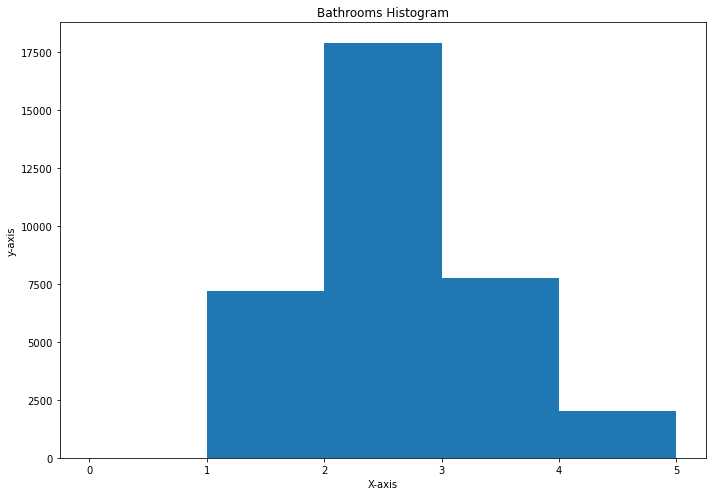

In [23]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7), tight_layout = True)
ax.hist(train.bathrooms, bins = [0, 1,2,3,4,5])
plt.xlabel("X-axis")
plt.ylabel("y-axis")
plt.title('Bathrooms Histogram')
 
# Show plot
plt.show()

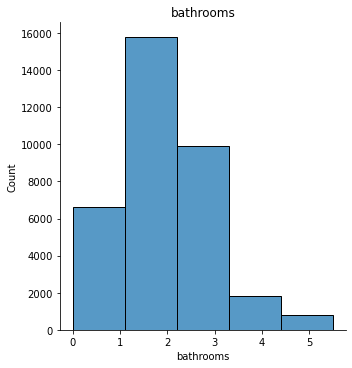

In [24]:
#Displot
sns.displot(x='bathrooms', data=train, bins=5)
plt.title('bathrooms')
plt.show()

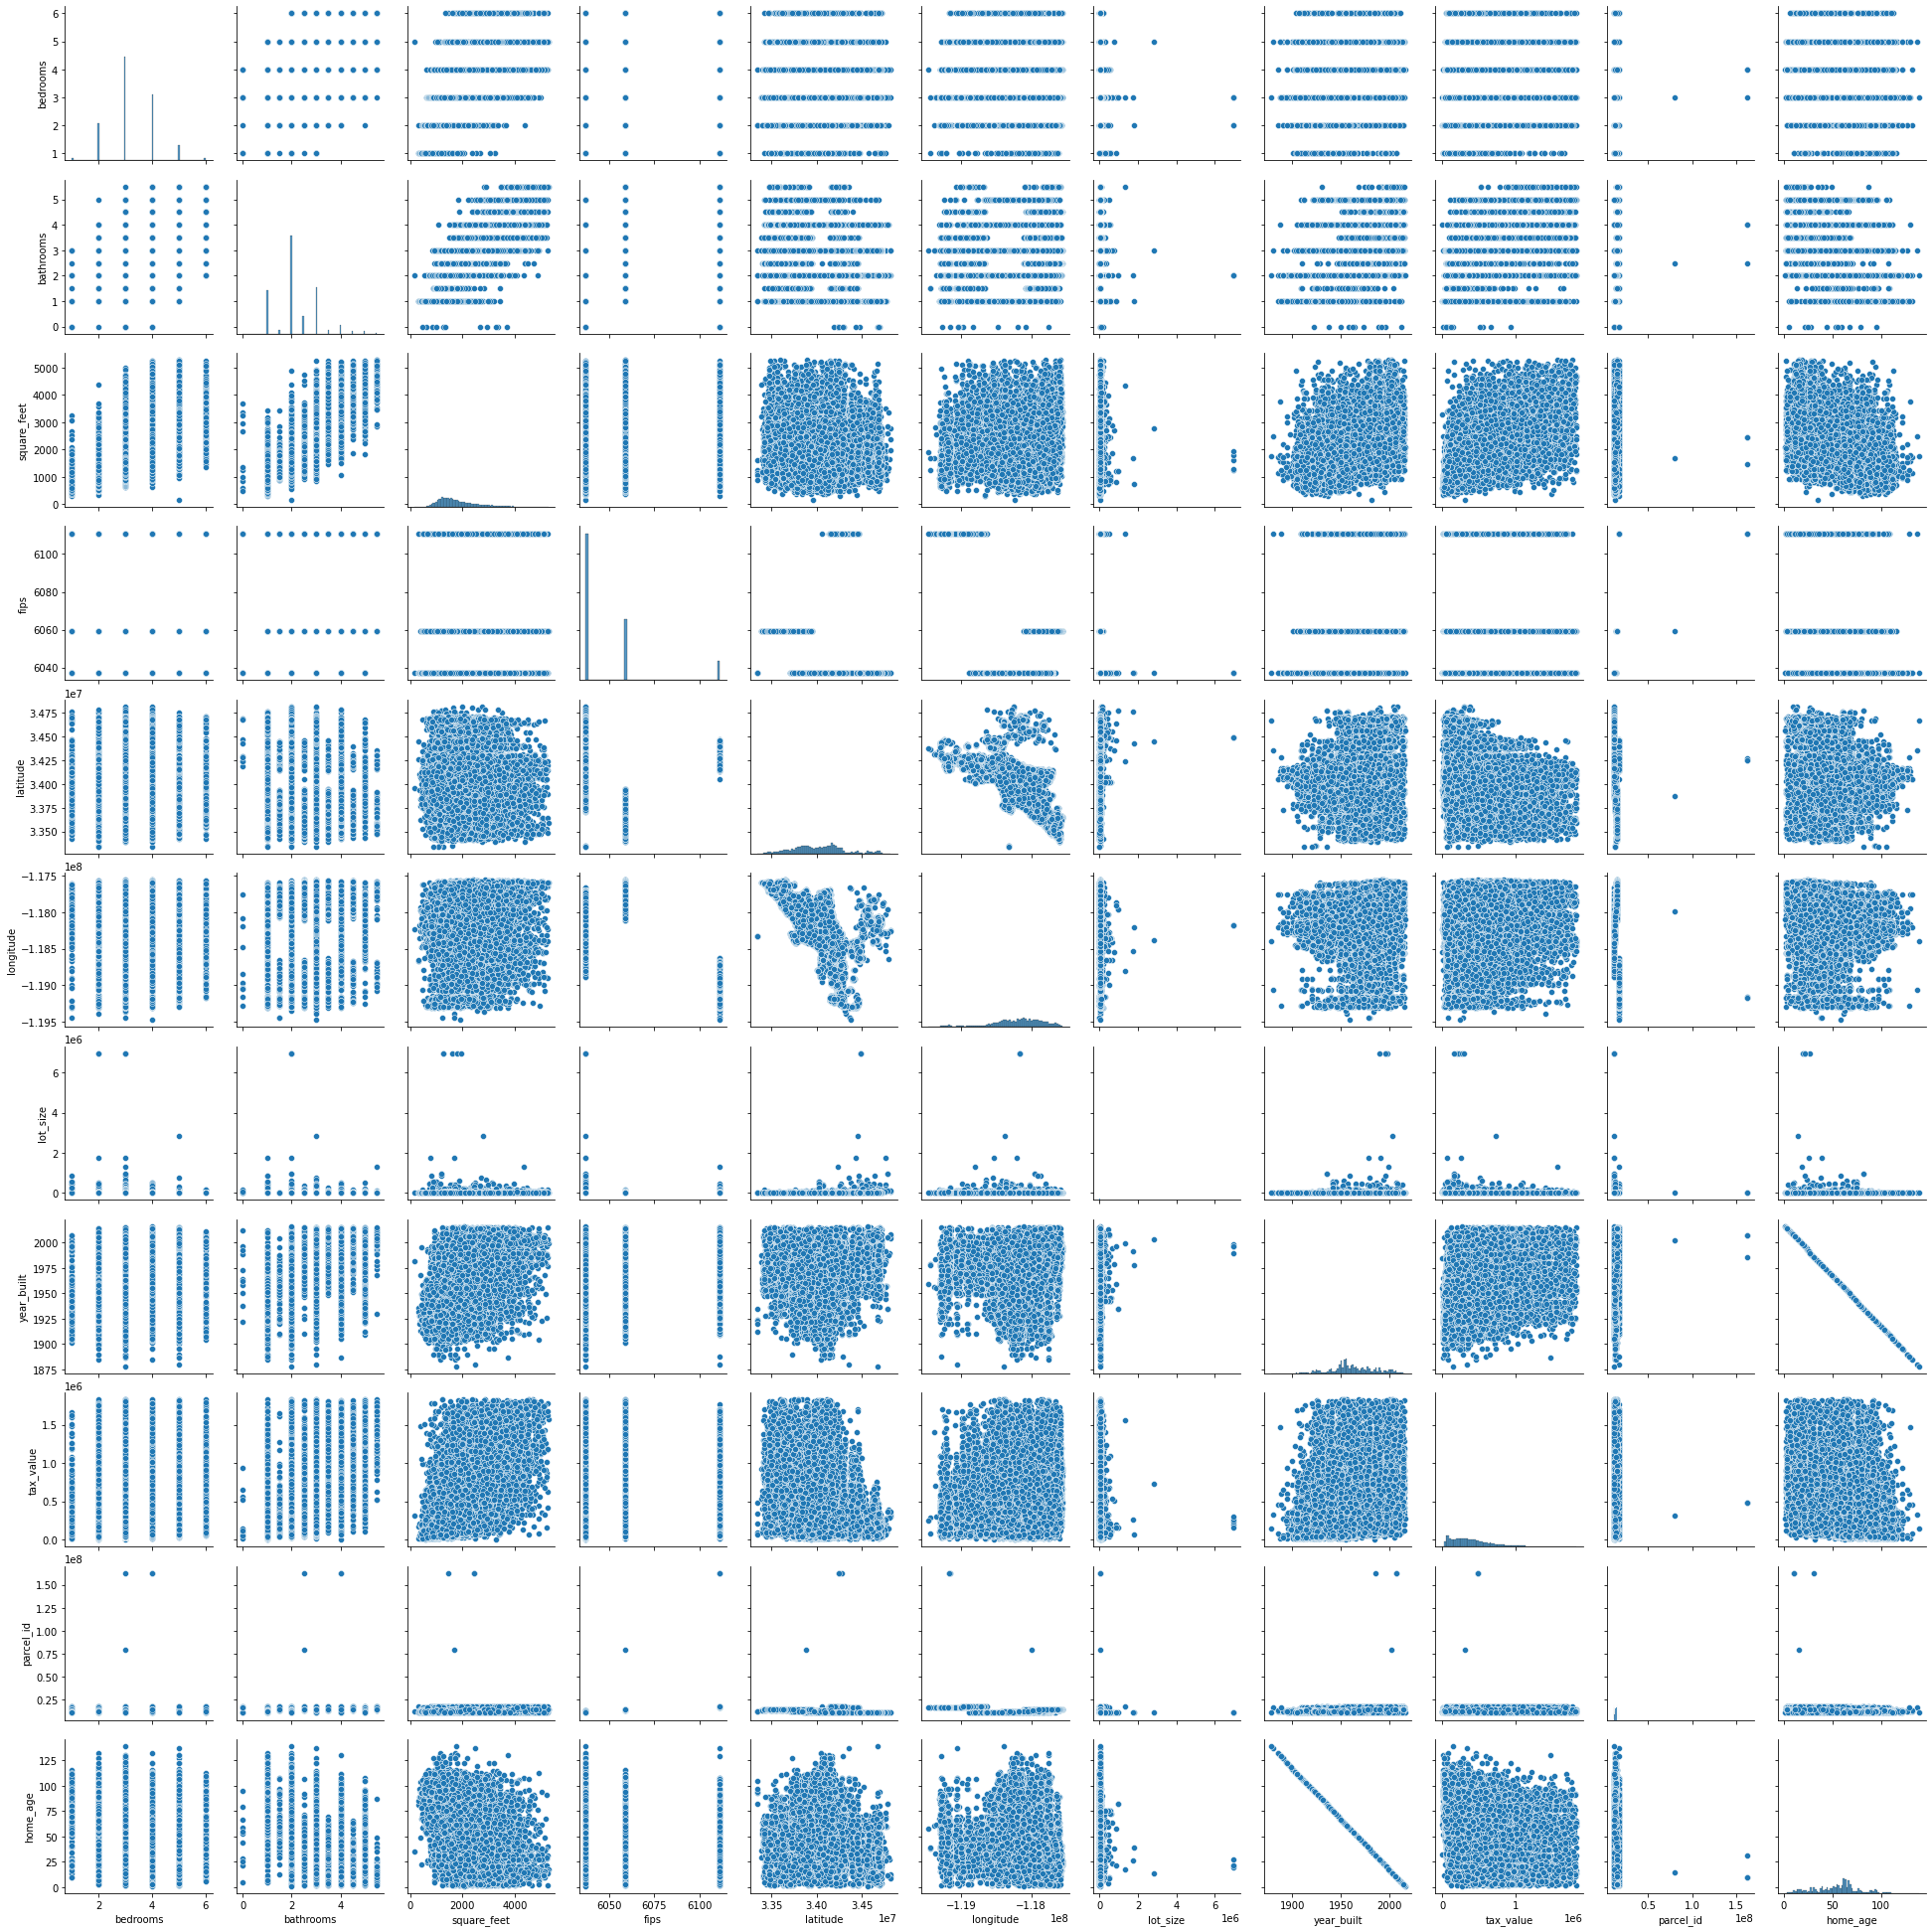

In [27]:
sns.pairplot(train)

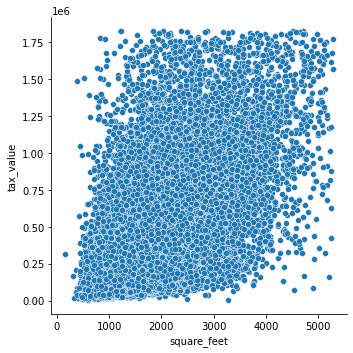

In [40]:
#Square Feet versus tax Value
sns.relplot(train['square_feet'], train['tax_value'], data=train)

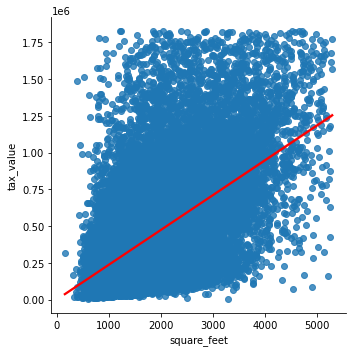

In [43]:
#Square Feet versus tax Value
sns.lmplot(x='square_feet', y='tax_value', data=train, scatter=True, line_kws={'color': 'red'})

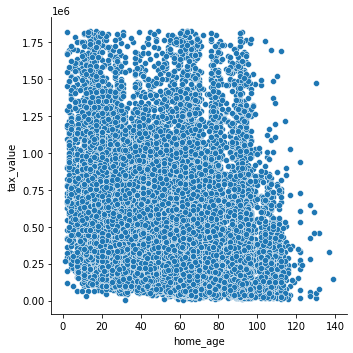

In [38]:
#bathrooms versus tax Value
sns.relplot(train['home_age'], train['tax_value'], data=train)

In [ ]:
sns.jointplot(x, y, data=train, kind=scatter)

In [ ]:
#Scale the data before further splitting
train, validate, test = m.scale_data(train, validate, test, columns_to_scale=['bedrooms', 'bathrooms', 'square_feet'], return_scaler=False)

In [ ]:
#Remove features not needed for modeling, returning a split between target and feature within train,
#validate, test
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model1_prep(train,validate,test)

In [ ]:
X_train.head(2)

In [26]:
#Visualizing Target Variable
plt.hist(y_train)
plt.xlabel('Tax Value')
plt.ylabel('Count of Homes')
plt.show()

NameError: name 'y_train' is not defined